In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn

In [2]:
X = np.arange(-1,1,0.001)
X.shape

(2000,)

In [3]:
y = 4*X**3 + 2**X + 3
y.shape

(2000,)

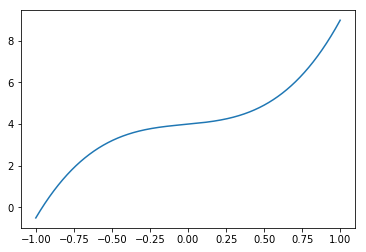

In [4]:
plt.plot(X,y)

## Implementation from Pytorch tutorial

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = nn.Linear(input_size+hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x, h):
        inp = torch.cat((x,h), 1)
        hidden = self.tanh(self.i2h(inp))
        output = self.h2o(inp)
        return hidden, output
    
    
    def get_output(self, X):
        time_steps = X.size(0)
        batch_size = X.size(1)
        hidden = Variable(torch.zeros(batch_size, self.hidden_size))
        outputs = []
        hiddens = []
        for t in range(time_steps):
            hidden, output = self.forward(X[t], hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(hiddens, 1), torch.cat(outputs, 1)
    
## Helper functions

def get_variable_from_np(X):
    return Variable(torch.from_numpy(X)).float()


def get_training_data(X, y, max_steps=10):
    inputs = []
    targets = []
    time_steps = X.shape[0]
    for i in range(0, time_steps, max_steps):
        inputs.append(get_variable_from_np(
            X[i:i+max_steps, np.newaxis, np.newaxis]))
        targets.append(get_variable_from_np(
            y[i:i+max_steps, np.newaxis, np.newaxis]))
    return torch.cat(inputs, 1), torch.cat(targets, 1)    

In [6]:
rnn = RNN(30, 20, 1)

In [7]:
criterion = nn.MSELoss()
batch_size = 10
TIMESTEPS = 5

batch = Variable(torch.randn(batch_size, 30))
hidden = Variable(torch.randn(batch_size, 20))
target = Variable(torch.randn(batch_size, 1))

loss = 0
for t in range(TIMESTEPS):
    hidden, output = rnn(batch, hidden)
    loss += criterion(output, target)
    
loss.backward()    

### Run on own data

In [8]:
rnn = RNN(1,3,1)

In [9]:
criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adadelta(rnn.parameters())

In [10]:
X[:, np.newaxis, np.newaxis].shape

(2000, 1, 1)

In [11]:
batch = get_variable_from_np(X[:, np.newaxis, np.newaxis])
hiddens, outputs = rnn.get_output(batch)

In [12]:
outputs

Variable containing:
 0.3605  0.3221  0.3861  ...  -0.3160 -0.3164 -0.3168
[torch.FloatTensor of size 1x2000]

In [13]:
target = get_variable_from_np(y[np.newaxis, :])
target

Variable containing:
-0.5000 -0.4877 -0.4754  ...   8.9600  8.9733  8.9866
[torch.FloatTensor of size 1x2000]

In [14]:
torch.cat([get_variable_from_np(X[i:i+10, np.newaxis, np.newaxis]) for i in range(5)], 1).size()

torch.Size([10, 5, 1])

In [15]:
torch.cat([get_variable_from_np(y[i:i+10, np.newaxis, np.newaxis]) for i in range(5)], 1).size()

torch.Size([10, 5, 1])

In [16]:
batch_size = 1
TIMESTEPS = X.shape[0]
epochs = 500
print_every = 50
inputs, targets = get_training_data(X, y, max_steps=1)
losses = []

optimizer.zero_grad()
for i in range(epochs):
    hiddens, outputs = rnn.get_output(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])
    if (i+1) % print_every == 0:
        print("Loss at epoch [%s]: %.3f" % (i, loss.data[0]))

Loss at epoch [49]: 11.593
Loss at epoch [99]: 1.054
Loss at epoch [149]: 4.781
Loss at epoch [199]: 16.875
Loss at epoch [249]: 17.653
Loss at epoch [299]: 7.151
Loss at epoch [349]: 0.812
Loss at epoch [399]: 6.405
Loss at epoch [449]: 16.412
Loss at epoch [499]: 17.247


In [17]:
outputs.data.numpy().flatten().shape

(2000,)

In [18]:
X.shape, outputs.data.numpy().flatten().shape

((2000,), (2000,))

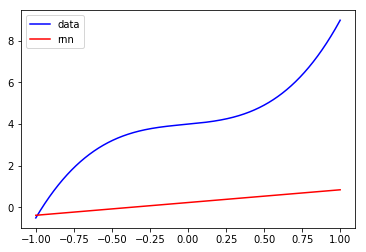

In [19]:
plt.plot(X,y, '-b', label='data')
plt.plot(X, outputs.data.numpy().flatten(), '-r', label='rnn')
plt.legend()

# Try to use the LSTM cells and LSTM layer (Work in progress)



## Use LSTM cell

In [20]:
input_size, hidden_size, output_size = 1,3,1
lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
output_layer = nn.Linear(hidden_size, output_size)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([
    {"params": lstm.parameters()},
    {"params": output_layer.parameters()}
], lr=0.001, momentum=0.9)

## Use LSTM Layer

In [22]:
lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
output_layer = nn.Linear(hidden_size, output_size)

In [23]:
batch = get_variable_from_np(X[:, np.newaxis, np.newaxis])
batch.size()

torch.Size([2000, 1, 1])

In [24]:
hidden = Variable(torch.zeros(1, batch.size(1), hidden_size))
cell_state = Variable(torch.zeros(1, batch.size(1), hidden_size))

In [25]:
hx = (hidden, cell_state)
output, (h_n, c_n) = lstm.forward(batch, hx)

In [26]:
output.size()

torch.Size([2000, 1, 3])

In [27]:
out = output_layer.forward(output[0])
out

Variable containing:
1.00000e-02 *
 -1.9964
[torch.FloatTensor of size 1x1]

In [28]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([
    {"params": lstm.parameters()},
    {"params": output_layer.parameters()}
], lr=0.001, momentum=0.9)

In [29]:
batch_size = 1
epochs = 10

for i in range(epochs):
    loss = 0
    optimizer.zero_grad()
    batch = get_variable_from_np(X[:, np.newaxis, np.newaxis])
    target = get_variable_from_np(y[:, np.newaxis, np.newaxis])
    hidden = Variable(torch.zeros(1, batch.size(1), hidden_size))
    cell_state = Variable(torch.zeros(1, batch.size(1), hidden_size))
    hx = (hidden, cell_state)
    output, (h_n, c_n) = lstm.forward(batch, hx)
    for j in range(output.size()[0]):
        out = output_layer.forward(output[i])
        loss += (out - target[i])**2
        #loss += criterion(out, target[i])
    loss = loss / X.shape[0]
    loss.backward()
    optimizer.step()
    print("Loss at epoch [%s]: %.3f" % (i, loss.squeeze().data[0]))

Loss at epoch [0]: 0.230
Loss at epoch [1]: 0.218
Loss at epoch [2]: 0.208
Loss at epoch [3]: 0.196
Loss at epoch [4]: 0.184
Loss at epoch [5]: 0.171
Loss at epoch [6]: 0.158
Loss at epoch [7]: 0.145
Loss at epoch [8]: 0.132
Loss at epoch [9]: 0.120


In [30]:
output.size()

torch.Size([2000, 1, 3])

In [31]:
out

Variable containing:
1.00000e-02 *
 -4.3584
[torch.FloatTensor of size 1x1]

In [32]:
target[i]

Variable containing:
-0.3898
[torch.FloatTensor of size 1x1]

In [33]:
y_pred = []
for i in range(output.size()[0]):
        out = output_layer.forward(output[i])
        y_pred.append(out.squeeze().data[0])
y_pred = np.array(y_pred)

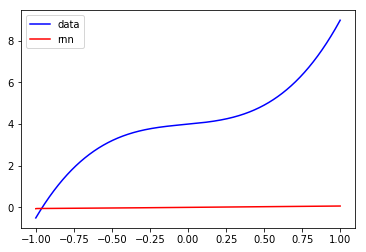

In [34]:
plt.plot(X,y, '-b', label='data')
plt.plot(X,y_pred, '-r', label='rnn')
plt.legend()